## Importaciones

In [1]:
import pandas as pd
import numpy as np
import random
from abc import ABC, abstractmethod
from itertools import permutations
import time
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

# FlowShopSolver

In [2]:
class FlowShopSolver(ABC):
    """Clase base para todos los algoritmos de Flow Shop Scheduling"""

    def __init__(self, times: Dict[int, List[float]]):
        """
        Args:
            times: Diccionario {job_id: [tiempo_m1, tiempo_m2, tiempo_m3, tiempo_m4]}
        """
        self.times = times
        self.job_ids = list(times.keys())
        self.n_jobs = len(times)
        self.n_machines = 4
        self.best_sequence = None
        self.best_makespan = float('inf')
        self.best_completion_times = None
        self.execution_time = 0

    def evaluate_sequence(self, sequence: List[int]) -> Tuple[float, List[float]]:
        """
        Evalúa una secuencia de trabajos y calcula el makespan

        Args:
            sequence: Lista de job_ids en el orden a ejecutar

        Returns:
            makespan: Tiempo total de finalización
            completion_times: Tiempos de finalización de cada trabajo
        """
        n = len(sequence)
        m = self.n_machines
        C = [[0] * m for _ in range(n)]

        # Primera fila
        C[0][0] = self.times[sequence[0]][0]
        for j in range(1, m):
            C[0][j] = C[0][j-1] + self.times[sequence[0]][j]

        # Resto de filas
        for i in range(1, n):
            C[i][0] = C[i-1][0] + self.times[sequence[i]][0]
            for j in range(1, m):
                C[i][j] = max(C[i-1][j], C[i][j-1]) + self.times[sequence[i]][j]

        completion_times = [C[i][m-1] for i in range(n)]
        makespan = completion_times[-1]

        return makespan, completion_times

    def calculate_metrics(self, completion_times: List[float], makespan: float) -> Tuple[float, float]:
        """
        Calcula métricas de rendimiento

        Returns:
            average_flow_time: Tiempo promedio de flujo
            throughput: Trabajos por unidad de tiempo
        """
        n = len(completion_times)
        average_flow_time = sum(completion_times) / n
        throughput = n / makespan if makespan > 0 else 0
        return average_flow_time, throughput

    @abstractmethod
    def solve(self) -> Tuple[List[int], float, float, float]:
        """
        Método abstracto que debe implementar cada algoritmo

        Returns:
            best_sequence: Mejor secuencia encontrada
            best_makespan: Makespan de la mejor secuencia
            average_flow_time: Tiempo promedio de flujo
            throughput: Throughput del sistema
        """
        pass

    def get_results(self) -> Dict:
        """Retorna un diccionario con todos los resultados"""
        if self.best_sequence is None:
            return None

        avg_flow, throughput = self.calculate_metrics(
            self.best_completion_times,
            self.best_makespan
        )

        return {
            'sequence': self.best_sequence,
            'makespan': self.best_makespan,
            'avg_flow_time': avg_flow,
            'throughput': throughput,
            'execution_time': self.execution_time
        }

## Algoritmo Genetico

In [3]:
class GeneticAlgorithm(FlowShopSolver):
    """Algoritmo Genético para Flow Shop Scheduling"""

    def __init__(self, times: Dict[int, List[float]],
                 pop_size: int = 50,
                 generations: int = 100,
                 crossover_rate: float = 0.8,
                 mutation_rate: float = 0.2,
                 selection_method: str = 'tournament',
                 crossover_method: str = 'ox',
                 mutation_method: str = 'swap'):
        super().__init__(times)
        self.pop_size = pop_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.selection_method = selection_method
        self.crossover_method = crossover_method
        self.mutation_method = mutation_method

    def generate_initial_population(self) -> List[List[int]]:
        """Genera población inicial aleatoria"""
        population = []
        for _ in range(self.pop_size):
            individual = self.job_ids[:]
            random.shuffle(individual)
            population.append(individual)
        return population

    def tournament_selection(self, population: List[List[int]],
                           fitnesses: List[float],
                           tournament_size: int = 3) -> List[List[int]]:
        """Selección por torneo"""
        selected = []
        for _ in range(len(population)):
            contestants = random.sample(range(len(population)), tournament_size)
            contestant_fitnesses = [fitnesses[i] for i in contestants]
            winner_index = contestants[contestant_fitnesses.index(min(contestant_fitnesses))]
            selected.append(population[winner_index])
        return selected

    def roulette_selection(self, population: List[List[int]],
                          fitnesses: List[float]) -> List[List[int]]:
        """Selección por ruleta"""
        max_fit = max(fitnesses)
        min_fit = min(fitnesses)
        normalized_fitnesses = [max_fit - f + (max_fit - min_fit) * 0.1 for f in fitnesses]
        total_fit = sum(normalized_fitnesses)
        if total_fit == 0:
            return random.choices(population, k=len(population))
        probabilities = [f / total_fit for f in normalized_fitnesses]
        selected = random.choices(population, weights=probabilities, k=len(population))
        return selected

    def order_crossover(self, parent1: List[int], parent2: List[int]) -> List[int]:
        """Cruce por orden (OX)"""
        size = len(parent1)
        start, end = sorted(random.sample(range(size), 2))
        child = [None] * size
        child[start:end+1] = parent1[start:end+1]
        parent2_index = (end + 1) % size
        child_index = (end + 1) % size
        while None in child:
            if parent2[parent2_index] not in child:
                child[child_index] = parent2[parent2_index]
                child_index = (child_index + 1) % size
            parent2_index = (parent2_index + 1) % size
        return child

    def pmx_crossover(self, parent1: List[int], parent2: List[int]) -> List[int]:
        """Cruce parcialmente mapeado (PMX)"""
        size = len(parent1)
        start, end = sorted(random.sample(range(size), 2))
        child = [None] * size
        child[start:end+1] = parent1[start:end+1]
        mapping = {}
        for i in range(start, end+1):
            mapping[parent1[i]] = parent2[i]
        for i in range(size):
            if child[i] is None:
                gene = parent2[i]
                while gene in mapping:
                    gene = mapping[gene]
                child[i] = gene
        return child

    def swap_mutation(self, individual: List[int]) -> List[int]:
        """Mutación por intercambio"""
        idx1, idx2 = random.sample(range(len(individual)), 2)
        individual[idx1], individual[idx2] = individual[idx2], individual[idx1]
        return individual

    def inversion_mutation(self, individual: List[int]) -> List[int]:
        """Mutación por inversión"""
        start, end = sorted(random.sample(range(len(individual)), 2))
        individual[start:end+1] = reversed(individual[start:end+1])
        return individual

    def solve(self) -> Tuple[List[int], float, float, float]:
        """Ejecuta el algoritmo genético"""
        start_time = time.time()

        population = self.generate_initial_population()

        for generation in range(self.generations):
            # Evaluación
            fitnesses = []
            completion_times_list = []
            for ind in population:
                makespan, comp_times = self.evaluate_sequence(ind)
                fitnesses.append(makespan)
                completion_times_list.append(comp_times)

            # Actualizar mejor solución
            current_best_fitness = min(fitnesses)
            if current_best_fitness < self.best_makespan:
                self.best_makespan = current_best_fitness
                best_index = fitnesses.index(current_best_fitness)
                self.best_sequence = population[best_index][:]
                self.best_completion_times = completion_times_list[best_index]

            # Selección
            if self.selection_method == 'tournament':
                selected = self.tournament_selection(population, fitnesses)
            else:
                selected = self.roulette_selection(population, fitnesses)

            # Cruce y mutación
            next_population = []
            for i in range(0, self.pop_size, 2):
                parent1 = selected[i]
                parent2 = selected[i+1] if i+1 < self.pop_size else selected[i]

                # Cruce
                if random.random() < self.crossover_rate:
                    if self.crossover_method == 'ox':
                        child1 = self.order_crossover(parent1, parent2)
                        child2 = self.order_crossover(parent2, parent1)
                    else:
                        child1 = self.pmx_crossover(parent1, parent2)
                        child2 = self.pmx_crossover(parent2, parent1)
                else:
                    child1 = parent1[:]
                    child2 = parent2[:]

                # Mutación
                if random.random() < self.mutation_rate:
                    if self.mutation_method == 'swap':
                        child1 = self.swap_mutation(child1)
                    else:
                        child1 = self.inversion_mutation(child1)

                if random.random() < self.mutation_rate:
                    if self.mutation_method == 'swap':
                        child2 = self.swap_mutation(child2)
                    else:
                        child2 = self.inversion_mutation(child2)

                next_population.append(child1)
                next_population.append(child2)

            # Elitismo
            if self.best_sequence is not None:
                next_population[0] = self.best_sequence[:]

            population = next_population[:self.pop_size]

        self.execution_time = time.time() - start_time
        avg_flow, throughput = self.calculate_metrics(
            self.best_completion_times,
            self.best_makespan
        )

        return self.best_sequence, self.best_makespan, avg_flow, throughput


## BruteForce

In [4]:
class BruteForce(FlowShopSolver):
    """Búsqueda por Fuerza Bruta (sampling aleatorio)"""

    def __init__(self, times: Dict[int, List[float]], max_iterations: int = 5000):
        super().__init__(times)
        self.max_iterations = max_iterations

    def solve(self) -> Tuple[List[int], float, float, float]:
        """Ejecuta búsqueda aleatoria"""
        start_time = time.time()

        rng = np.random.default_rng()

        for _ in range(self.max_iterations):
            sequence = rng.permutation(self.job_ids).tolist()
            makespan, completion_times = self.evaluate_sequence(sequence)

            if makespan < self.best_makespan:
                self.best_makespan = makespan
                self.best_sequence = sequence[:]
                self.best_completion_times = completion_times

        self.execution_time = time.time() - start_time
        avg_flow, throughput = self.calculate_metrics(
            self.best_completion_times,
            self.best_makespan
        )

        return self.best_sequence, self.best_makespan, avg_flow, throughput


## Shortest Processing Time

In [5]:
class ShortestProcessingTime(FlowShopSolver):
    """Heurística de Tiempo de Procesamiento Más Corto"""

    def __init__(self, times: Dict[int, List[float]], criterion: str = 'total'):
        super().__init__(times)
        self.criterion = criterion

    def solve(self) -> Tuple[List[int], float, float, float]:
        """Ordena trabajos por tiempo de procesamiento"""
        start_time = time.time()

        if self.criterion == 'total':
            sequence = sorted(self.job_ids, key=lambda j: sum(self.times[j]))
        else:  # first_machine
            sequence = sorted(self.job_ids, key=lambda j: self.times[j][0])

        makespan, completion_times = self.evaluate_sequence(sequence)

        self.best_sequence = sequence
        self.best_makespan = makespan
        self.best_completion_times = completion_times
        self.execution_time = time.time() - start_time

        avg_flow, throughput = self.calculate_metrics(completion_times, makespan)

        return sequence, makespan, avg_flow, throughput

## Least Work Load

In [6]:
class LeastWorkLoad(FlowShopSolver):
    """Heurística de Menor Carga de Trabajo"""

    def solve(self) -> Tuple[List[int], float, float, float]:
        """Construcción greedy: agrega trabajo que minimiza makespan"""
        start_time = time.time()

        remaining = self.job_ids[:]
        sequence = []

        while remaining:
            best_job = None
            best_makespan_local = float('inf')

            for job in remaining:
                trial_sequence = sequence + [job]
                trial_makespan, _ = self.evaluate_sequence(trial_sequence)

                if trial_makespan < best_makespan_local:
                    best_makespan_local = trial_makespan
                    best_job = job

            sequence.append(best_job)
            remaining.remove(best_job)

        makespan, completion_times = self.evaluate_sequence(sequence)

        self.best_sequence = sequence
        self.best_makespan = makespan
        self.best_completion_times = completion_times
        self.execution_time = time.time() - start_time

        avg_flow, throughput = self.calculate_metrics(completion_times, makespan)

        return sequence, makespan, avg_flow, throughput

## Validación

In [7]:
tiempos = {
    1: [10, 20, 15, 25],
    2: [15, 18, 22, 20],
    3: [12, 25, 18, 15],
    4: [20, 15, 20, 18],
    5: [18, 22, 16, 22]}

solver = GeneticAlgorithm(tiempos, pop_size=50, generations=100,
                          selection_method='tournament',
                          crossover_method='ox',
                          mutation_method='swap')
sequence, makespan, avg_flow, throughput = solver.solve()

ej_df =  pd.DataFrame([solver.get_results()], index=[0])
ej_df

,sequence,makespan,avg_flow_time,throughput,execution_time
0,"[1, 2, 5, 4, 3]",145,109.4,0.034483,0.041986


# Benchmark

In [8]:
class FlowShopBenchmark:
    """Sistema de benchmark para comparar algoritmos"""

    def __init__(self, file_paths: List[str]):
        self.file_paths = file_paths
        self.results = []

    def load_data(self, file_path: str) -> Dict[int, List[float]]:
        """Carga datos desde Excel"""
        df = pd.read_excel(file_path)
        times = {}
        for index, row in df.iterrows():
            job_id = int(row['ID_Trabajo'])
            times[job_id] = [
                row['Limpieza de Botellas (M1)'],
                row['Llenado (M2)'],
                row['Taponado (M3)'],
                row['Etiquetado (M4)']
            ]
        return times

    def run_benchmark(self):
        """Ejecuta benchmark en todos los datasets"""
        algorithms = {
            'GeneticAlgorithm': lambda times: GeneticAlgorithm(
                times, pop_size=50, generations=100,
                selection_method='tournament',
                crossover_method='ox',
                mutation_method='swap'
            ),
            'BruteForce': lambda times: BruteForce(times, max_iterations=5000),
            'ShortestProcessingTime': lambda times: ShortestProcessingTime(times, 'total'),
            'LeastWorkLoad': lambda times: LeastWorkLoad(times)
        }

        for file_path in self.file_paths:
            print(f"\n{'='*60}")
            print(f"Dataset: {file_path}")
            print('='*60)

            times = self.load_data(file_path)

            for alg_name, alg_constructor in algorithms.items():
                print(f"\nEjecutando {alg_name}...")

                solver = alg_constructor(times)
                sequence, makespan, avg_flow, throughput = solver.solve()

                self.results.append({
                    'dataset': file_path,
                    'algorithm': alg_name,
                    'sequence': sequence,
                    'makespan': makespan,
                    'avg_flow_time': avg_flow,
                    'throughput': throughput,
                    'execution_time': solver.execution_time
                })

                print(f"  Makespan: {makespan:.2f}")
                print(f"  Avg Flow Time: {avg_flow:.2f}")
                print(f"  Throughput: {throughput:.6f}")
                print(f"  Tiempo de ejecución: {solver.execution_time:.4f}s")

    def get_results_dataframe(self) -> pd.DataFrame:
        """Retorna resultados como DataFrame"""
        return pd.DataFrame(self.results)

    def generate_comparison_report(self) -> pd.DataFrame:
        """Genera reporte comparativo por dataset"""
        df = self.get_results_dataframe()

        # Crear pivot table para comparación
        comparison = df.pivot_table(
            index='dataset',
            columns='algorithm',
            values=['makespan', 'avg_flow_time', 'throughput', 'execution_time'],
            aggfunc='first'
        )

        return comparison

    def find_best_algorithm(self) -> pd.DataFrame:
        """Encuentra el mejor algoritmo por dataset"""
        df = self.get_results_dataframe()

        best_results = []
        for dataset in df['dataset'].unique():
            dataset_df = df[df['dataset'] == dataset]
            best_makespan_idx = dataset_df['makespan'].idxmin()
            best_row = dataset_df.loc[best_makespan_idx]

            best_results.append({
                'dataset': dataset,
                'best_algorithm': best_row['algorithm'],
                'makespan': best_row['makespan'],
                'improvement_vs_worst': (
                    (dataset_df['makespan'].max() - best_row['makespan']) /
                    dataset_df['makespan'].max() * 100
                )
            })

        return pd.DataFrame(best_results)

## Resultados

In [9]:
if __name__ == "__main__":
    file_paths = ['Dataset_Pequeño_1.xlsx','Dataset_Pequeño_2.xlsx','Dataset_Pequeño_3.xlsx',
                  'Dataset_Pequeño_4.xlsx','Dataset_Mediano_1.xlsx','Dataset_Mediano_2.xlsx',
                  'Dataset_Mediano_3.xlsx','Dataset_Mediano_4.xlsx','Dataset_Grande_1.xlsx',
                  'Dataset_Grande_2.xlsx' ]

    # Install openpyxl if not already installed
    try:
        import openpyxl
    except ImportError:
        !pip install openpyxl

    # Ejecutar benchmark
    benchmark = FlowShopBenchmark(file_paths)
    benchmark.run_benchmark()

    # Obtener resultados
    results_df = benchmark.get_results_dataframe()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 7.8 MB/s eta 0:00:00

Dataset: Dataset_Pequeño_1.xlsx

Ejecutando GeneticAlgorithm...
  Makespan: 427.00
  Avg Flow Time: 347.80
  Throughput: 0.011710
  Tiempo de ejecución: 0.0406s

Ejecutando BruteForce...
  Makespan: 427.00
  Avg Flow Time: 338.20
  Throughput: 0.011710
  Tiempo de ejecución: 0.0386s

Ejecutando ShortestProcessingTime...
  Makespan: 531.00
  Avg Flow Time: 328.00
  Throughput: 0.009416
  Tiempo de ejecución: 0.0000s

Ejecutando LeastWorkLoad...
  Makespan: 497.00
  Avg Flow Time: 307.40
  Throughput: 0.010060
  Tiempo de ejecución: 0.0000s

Dataset: Dataset_Pequeño_2.xlsx

Ejecutando GeneticAlgorithm...
  Makespan: 716.00
  Avg Flow Time: 468.62
  Throughput: 0.011173
  Tiempo de ejecución: 0.0560s

Ejecutando BruteForce...
  Makespan: 720.00
  Avg Flow Time: 495.12
  Throughput: 0.011111
  Tiempo de ejecución: 0.0572s

Ejecutando ShortestProcessingTime...
  Makespan: 779.00
  Avg Flow Time: 446.50
  Throug

In [10]:

results_df.to_excel('benchmark_results.xlsx', index=False)

In [11]:
results_df

,dataset,algorithm,sequence,makespan,avg_flow_time,throughput,execution_time
0,Dataset_Pequeño_1.xlsx,GeneticAlgorithm,"[3, 4, 1, 2, 5]",427,347.800000,0.011710,0.040647
1,Dataset_Pequeño_1.xlsx,BruteForce,"[3, 4, 5, 1, 2]",427,338.200000,0.011710,0.038591
2,Dataset_Pequeño_1.xlsx,ShortestProcessingTime,"[5, 1, 3, 2, 4]",531,328.000000,0.009416,0.000010
3,Dataset_Pequeño_1.xlsx,LeastWorkLoad,"[5, 1, 2, 3, 4]",497,307.400000,0.010060,0.000045
4,Dataset_Pequeño_2.xlsx,GeneticAlgorithm,"[2, 5, 6, 8, 4, 7, 3, 1]",716,468.625000,0.011173,0.056024
5,Dataset_Pequeño_2.xlsx,BruteForce,"[5, 8, 6, 2, 4, 7, 3, 1]",720,495.125000,0.011111,0.057169
6,Dataset_Pequeño_2.xlsx,ShortestProcessingTime,"[1, 2, 5, 6, 8, 7, 3, 4]",779,446.500000,0.010270,0.000015
7,Dataset_Pequeño_2.xlsx,LeastWorkLoad,"[1, 2, 6, 8, 5, 7, 3, 4]",779,443.250000,0.010270,0.000123
8,Dataset_Pequeño_3.xlsx,GeneticAlgorithm,"[6, 5, 3, 1, 2, 4]",461,336.666667,0.013015,0.046422
9,Dataset_Pequeño_3.xlsx,BruteForce,"[6, 5, 3, 1, 2, 4]",461,336.666667,0.013015,0.042257


# Analisis estadistico

In [12]:
class BenchmarkAnalyzer:
    """Análisis estadístico de resultados del benchmark"""

    def __init__(self, results_df: pd.DataFrame):
        self.df = results_df

    def algorithm_performance_summary(self) -> pd.DataFrame:
        """Resumen estadístico por algoritmo"""
        summary = self.df.groupby('algorithm').agg({
            'makespan': ['mean', 'std', 'min', 'max'],
            'avg_flow_time': ['mean', 'std'],
            'throughput': ['mean', 'std'],
            'execution_time': ['mean', 'std', 'max']
        }).round(4)

        summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
        return summary

    def dataset_size_analysis(self) -> pd.DataFrame:
        """Análisis por tamaño de dataset"""
        def classify_size(dataset_name):
            if 'Pequeño' in dataset_name:
                return 'Pequeño'
            elif 'Mediano' in dataset_name:
                return 'Mediano'
            elif 'Grande' in dataset_name:
                return 'Grande'
            return 'Desconocido'

        self.df['size_category'] = self.df['dataset'].apply(classify_size)

        size_analysis = self.df.groupby(['size_category', 'algorithm']).agg({
            'makespan': 'mean',
            'execution_time': 'mean'
        }).round(4)

        return size_analysis

    def algorithm_ranking(self) -> pd.DataFrame:
        """Ranking de algoritmos por métrica"""
        rankings = []

        for dataset in self.df['dataset'].unique():
            dataset_df = self.df[self.df['dataset'] == dataset]

            # Ranking por makespan (menor es mejor)
            makespan_rank = dataset_df.nsmallest(4, 'makespan')[['algorithm', 'makespan']].copy()
            makespan_rank['rank'] = range(1, len(makespan_rank) + 1)
            makespan_rank['metric'] = 'makespan'
            makespan_rank['dataset'] = dataset

            # Ranking por tiempo de ejecución (menor es mejor)
            time_rank = dataset_df.nsmallest(4, 'execution_time')[['algorithm', 'execution_time']].copy()
            time_rank['rank'] = range(1, len(time_rank) + 1)
            time_rank['metric'] = 'execution_time'
            time_rank['dataset'] = dataset

            rankings.append(makespan_rank[['dataset', 'algorithm', 'metric', 'rank']])
            rankings.append(time_rank[['dataset', 'algorithm', 'metric', 'rank']])

        ranking_df = pd.concat(rankings, ignore_index=True)

        # Ranking promedio por algoritmo y métrica
        avg_ranking = ranking_df.groupby(['algorithm', 'metric'])['rank'].mean().round(2)

        return avg_ranking.reset_index()

    def relative_performance(self) -> pd.DataFrame:
        """Rendimiento relativo respecto al mejor"""
        relative_results = []

        for dataset in self.df['dataset'].unique():
            dataset_df = self.df[self.df['dataset'] == dataset]
            best_makespan = dataset_df['makespan'].min()

            for _, row in dataset_df.iterrows():
                gap = ((row['makespan'] - best_makespan) / best_makespan) * 100
                relative_results.append({
                    'dataset': dataset,
                    'algorithm': row['algorithm'],
                    'makespan': row['makespan'],
                    'gap_percent': gap,
                    'is_best': gap == 0
                })

        return pd.DataFrame(relative_results)

    def convergence_analysis(self) -> pd.DataFrame:
        """Análisis de calidad/tiempo de ejecución"""
        analysis = self.df.copy()

        # Normalizar makespan y tiempo por dataset
        for dataset in analysis['dataset'].unique():
            mask = analysis['dataset'] == dataset

            min_makespan = analysis.loc[mask, 'makespan'].min()
            max_makespan = analysis.loc[mask, 'makespan'].max()

            if max_makespan > min_makespan:
                analysis.loc[mask, 'normalized_makespan'] = (
                    (analysis.loc[mask, 'makespan'] - min_makespan) /
                    (max_makespan - min_makespan)
                )
            else:
                analysis.loc[mask, 'normalized_makespan'] = 0

        # Calcular efficiency score (menor makespan / menor tiempo)
        analysis['efficiency_score'] = (
            1 / (1 + analysis['normalized_makespan']) *
            1 / (1 + analysis['execution_time'])
        )

        return analysis[['dataset', 'algorithm', 'normalized_makespan',
                        'execution_time', 'efficiency_score']]

    def win_count(self) -> pd.DataFrame:
        """Cuenta cuántas veces cada algoritmo fue el mejor"""
        wins = []

        for dataset in self.df['dataset'].unique():
            dataset_df = self.df[self.df['dataset'] == dataset]
            best_makespan = dataset_df['makespan'].min()
            winner = dataset_df[dataset_df['makespan'] == best_makespan]['algorithm'].iloc[0]
            wins.append(winner)

        win_counts = pd.Series(wins).value_counts()
        return win_counts.to_frame('wins').reset_index()

    def generate_comparison_table(self) -> pd.DataFrame:
        """Tabla comparativa completa"""
        comparison = self.df.pivot_table(
            index='dataset',
            columns='algorithm',
            values=['makespan', 'avg_flow_time', 'throughput', 'execution_time']
        )

        return comparison

    def statistical_test_summary(self) -> Dict:
        """Resumen de tests estadísticos"""
        from scipy import stats

        algorithms = self.df['algorithm'].unique()
        results = {}

        if len(algorithms) >= 2:
            # Test de Friedman (no paramétrico para múltiples algoritmos)
            datasets = self.df['dataset'].unique()
            makespan_matrix = []

            for dataset in datasets:
                dataset_makespans = self.df[self.df['dataset'] == dataset]['makespan'].values
                makespan_matrix.append(dataset_makespans)

            makespan_matrix = np.array(makespan_matrix)

            try:
                friedman_stat, friedman_p = stats.friedmanchisquare(*makespan_matrix.T)
                results['friedman_test'] = {
                    'statistic': friedman_stat,
                    'p_value': friedman_p,
                    'significant': friedman_p < 0.05
                }
            except:
                results['friedman_test'] = 'No se pudo realizar'

        return results

    def export_analysis(self, output_file: str = 'benchmark_analysis.xlsx'):
        """Exporta todos los análisis a Excel"""
        with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
            self.df.to_excel(writer, sheet_name='Raw_Data', index=False)
            self.algorithm_performance_summary().to_excel(writer, sheet_name='Performance_Summary')
            self.dataset_size_analysis().to_excel(writer, sheet_name='Size_Analysis')
            self.algorithm_ranking().to_excel(writer, sheet_name='Rankings', index=False)
            self.relative_performance().to_excel(writer, sheet_name='Relative_Performance', index=False)
            self.win_count().to_excel(writer, sheet_name='Win_Count', index=False)
            self.generate_comparison_table().to_excel(writer, sheet_name='Comparison_Table')

        print(f"Análisis exportado a {output_file}")


###Vizualizacion

In [13]:
def visualize_results(results_df: pd.DataFrame):
    """Genera visualizaciones de los resultados"""

    # Configuración de estilo
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (15, 10)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Makespan por algoritmo y dataset
    pivot_makespan = results_df.pivot(index='dataset',
                                       columns='algorithm',
                                       values='makespan')

    ax1 = axes[0, 0]
    pivot_makespan.plot(kind='bar', ax=ax1)
    ax1.set_title('Makespan por Algoritmo y Dataset', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Dataset')
    ax1.set_ylabel('Makespan')
    ax1.legend(title='Algoritmo', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)

    # 2. Tiempo de ejecución
    ax2 = axes[0, 1]
    results_df.boxplot(column='execution_time', by='algorithm', ax=ax2)
    ax2.set_title('Distribución de Tiempo de Ejecución', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Algoritmo')
    ax2.set_ylabel('Tiempo (segundos)')
    plt.sca(ax2)
    plt.xticks(rotation=45)

    # 3. Throughput comparativo
    ax3 = axes[1, 0]
    avg_throughput = results_df.groupby('algorithm')['throughput'].mean().sort_values()
    avg_throughput.plot(kind='barh', ax=ax3, color='skyblue')
    ax3.set_title('Throughput Promedio por Algoritmo', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Throughput')
    ax3.set_ylabel('Algoritmo')

    # 4. Heatmap de rendimiento normalizado
    ax4 = axes[1, 1]

    # Normalizar makespan por dataset
    normalized_data = []
    for dataset in results_df['dataset'].unique():
        dataset_df = results_df[results_df['dataset'] == dataset]
        min_val = dataset_df['makespan'].min()
        max_val = dataset_df['makespan'].max()

        for _, row in dataset_df.iterrows():
            if max_val > min_val:
                norm_val = (row['makespan'] - min_val) / (max_val - min_val)
            else:
                norm_val = 0
            normalized_data.append({
                'dataset': dataset,
                'algorithm': row['algorithm'],
                'normalized_makespan': norm_val
            })

    norm_df = pd.DataFrame(normalized_data)
    heatmap_data = norm_df.pivot(index='dataset',
                                  columns='algorithm',
                                  values='normalized_makespan')

    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn_r',
                ax=ax4, cbar_kws={'label': 'Makespan Normalizado'})
    ax4.set_title('Rendimiento Normalizado (0=mejor, 1=peor)',
                  fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('benchmark_visualization.png', dpi=300, bbox_inches='tight')
    print("Visualización guardada en 'benchmark_visualization.png'")

    return fig


RESUMEN DE RENDIMIENTO POR ALGORITMO
                        makespan_mean  makespan_std  makespan_min  \
algorithm                                                           
BruteForce                     1310.8      976.8034           427   
GeneticAlgorithm               1309.9      974.2889           427   
LeastWorkLoad                  1470.1     1099.4368           454   
ShortestProcessingTime         1441.9     1021.4038           454   

                        makespan_max  avg_flow_time_mean  avg_flow_time_std  \
algorithm                                                                     
BruteForce                      3237            795.8503           498.6052   
GeneticAlgorithm                3231            798.7389           494.6839   
LeastWorkLoad                   3692            759.5512           504.8591   
ShortestProcessingTime          3449            732.5428           457.3527   

                        throughput_mean  throughput_std  execution_time_

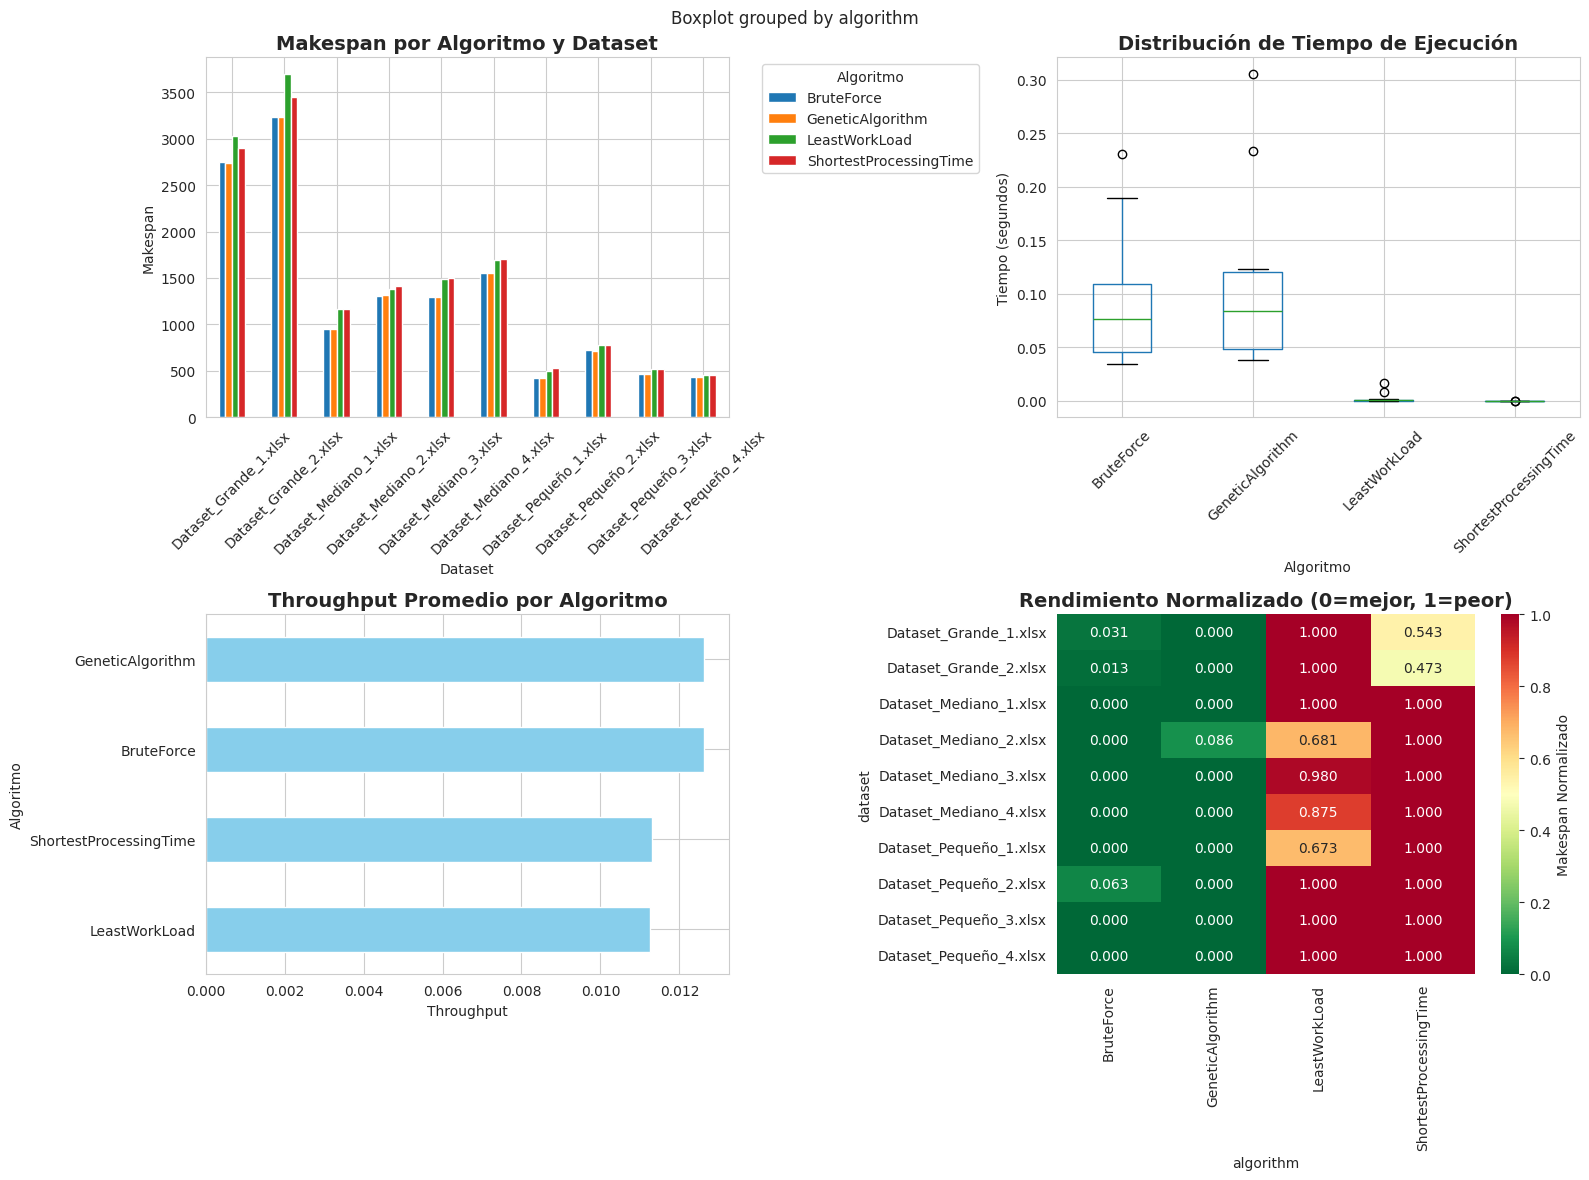

In [14]:
if __name__ == "__main__":

    # Crear analizador
    analyzer = BenchmarkAnalyzer(results_df)

    # Mostrar análisis
    print("\n" + "="*70)
    print("RESUMEN DE RENDIMIENTO POR ALGORITMO")
    print("="*70)
    print(analyzer.algorithm_performance_summary())

    print("\n" + "="*70)
    print("ANÁLISIS POR TAMAÑO DE DATASET")
    print("="*70)
    print(analyzer.dataset_size_analysis())

    print("\n" + "="*70)
    print("RANKING PROMEDIO DE ALGORITMOS")
    print("="*70)
    print(analyzer.algorithm_ranking())

    print("\n" + "="*70)
    print("RENDIMIENTO RELATIVO")
    print("="*70)
    print(analyzer.relative_performance())



    analyzer.export_analysis('benchmark_analysis_complete.xlsx')

    # Generar visualizaciones
    visualize_results(results_df)